---
title: 2D Navier-Stokes
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes
    * 2D NavierStokes (Cavity Flow) -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb)

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial x} +
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial y} +
\nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial^2 p}{\partial x^2} &+ \frac{\partial^2 p}{\partial y^2}  =
-\rho\left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$ (eq:2d_ns)

where $\nu$ is the diffusivity. Here, we are advised to:
* Diffusion Term - 2nd order accurate central difference scheme
* Advection Term - 1st order accuracy backwards difference scheme
* Time Step - 1st order temporal scheme (Euler).
* Initialization - same hat
* Boundaries - 1's everywhere

## Domain

In [2]:
nx, ny = 41, 41
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [3]:
domain = Domain.from_numpoints(
    xmin=(xmin,ymin), 
    xmax=(xmax,ymax), N=(nx,ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (41, 41)
nDims: 2
Grid Size: (41, 41, 2)
Cell Volume: 0.0025000000000000005


### State

So we have 3 variables, $u,v,p$. We will use the nifty state container that we did for the Burger's example.

We also have 2 constants that we need to keep track of, $\rho,\nu$.

In [4]:
from typing import Optional, NamedTuple, Callable

class State(NamedTuple):
    u: Array
    v: Array
    p: Array
    domain: Domain
    nu: float
    rho: float
    
    
    @classmethod
    def init_state(
        cls, domain: Domain, nu: float, rho: float, init_fn: Callable
    ):
        
        u = init_fn(domain)
        v = init_fn(domain)
        p = init_fn(domain)
        
        return cls(u=u, v=v, p=p, domain=domain, nu=nu, rho=rho)
    
    @staticmethod
    def update_state(
        state, u=None, v=None, p=None, rho=None, nu=None, domain=None
    ):
        
        return State(
            u=u if u is not None else state.u,
            v=v if v is not None else state.v,
            p=p if p is not None else state.p,
            nu=nu if nu is not None else state.nu,
            rho=rho if rho is not None else state.rho,
            domain=domain if domain is not None else state.domain
        )
    

### Initial Conditions

We're doing the same hat initialization as before.

$$
\begin{aligned}
\mathcal{IC}[u,v,p](\mathbf{x}) &= 0, && && \mathbf{x}\in(\Omega,\partial\Omega)
\end{aligned}
$$

In [5]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.ones(domain.size, dtype=jnp.float64)
    v = jnp.ones(domain.size, dtype=jnp.float64)
    p = jnp.ones(domain.size, dtype=jnp.float64)
    return u

#### Demo Plot

In [6]:
nu = 0.1
rho = 1.0

state = State.init_state(domain, nu=nu, rho=rho, init_fn=init_u0)


# # update state (manually)
# state_update = State(u=state_init.u, v=state_init.v, domain=state_init.domain, nu=state_init.nu)

# # update state (convenience function)
# state_update_ = State.update_state(state_init, u=state_init.u, v=state_init.v)

# assert state_update == state_update_

In [7]:
from matplotlib import cm

def plot_state_3D(state, axis=None):
    fig, ax = plt.subplots(
    ncols=3, figsize=(15,5),subplot_kw={"projection": "3d"})

    surf = ax[0].plot_surface(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.u[axis] if axis is not None else state.u, 
        cmap=cm.viridis
    )

    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[0].set(title="u-velocity")
    
    surf = ax[1].plot_surface(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.v[axis] if axis is not None else state.v, 
        cmap=cm.viridis
    )
    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[1].set(title="v-velocity")

    # Pressure
    surf = ax[2].plot_surface(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.p[axis] if axis is not None else state.p, 
        cmap=cm.viridis
    )
    ax[2].set(title="Pressure")
    plt.colorbar(surf, shrink=0.4, aspect=12)
    plt.tight_layout()
    plt.show()
    
    
def plot_state_2D(state, axis=None):
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))

    surf = ax[0].pcolormesh(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.u[axis] if axis is not None else state.u, 
        cmap=cm.viridis
    )

    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[0].set(title="u-velocity")
    
    surf = ax[1].pcolormesh(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.v[axis] if axis is not None else state.v, 
        cmap=cm.viridis
    )
    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[1].set(title="v-velocity")

    # Pressure
    surf = ax[2].pcolormesh(
        state.domain.grid[...,0], 
        state.domain.grid[...,1], 
        state.p[axis] if axis is not None else state.p, 
        cmap=cm.viridis
    )
    ax[2].set(title="Pressure")
    plt.colorbar(surf, shrink=0.4, aspect=12)
    plt.tight_layout()
    plt.show()
    
def plot_vectorfield_2D(state, axis=None):
    fig, ax = plt.subplots(figsize=(5,4))
    # pressure field as contour
    pts = ax.contourf(
        state.domain.grid[...,0],
        state.domain.grid[...,1],
        state.p[axis] if axis is not None else state.p,
        alpha=0.5, cmap=cm.viridis
    )
    # pressure field outlines
    ax.contour(
        state.domain.grid[...,0],
        state.domain.grid[...,1],
        state.p[axis] if axis is not None else state.p,
        alpha=0.5, cmap=cm.viridis
    )
    # velocity field
    ax.quiver(
        state.domain.grid[...,0],
        state.domain.grid[...,1],
        state.u[axis] if axis is not None else state.v,
        state.v[axis] if axis is not None else state.v,
    )
    plt.colorbar(pts)
    plt.tight_layout()
    plt.show()

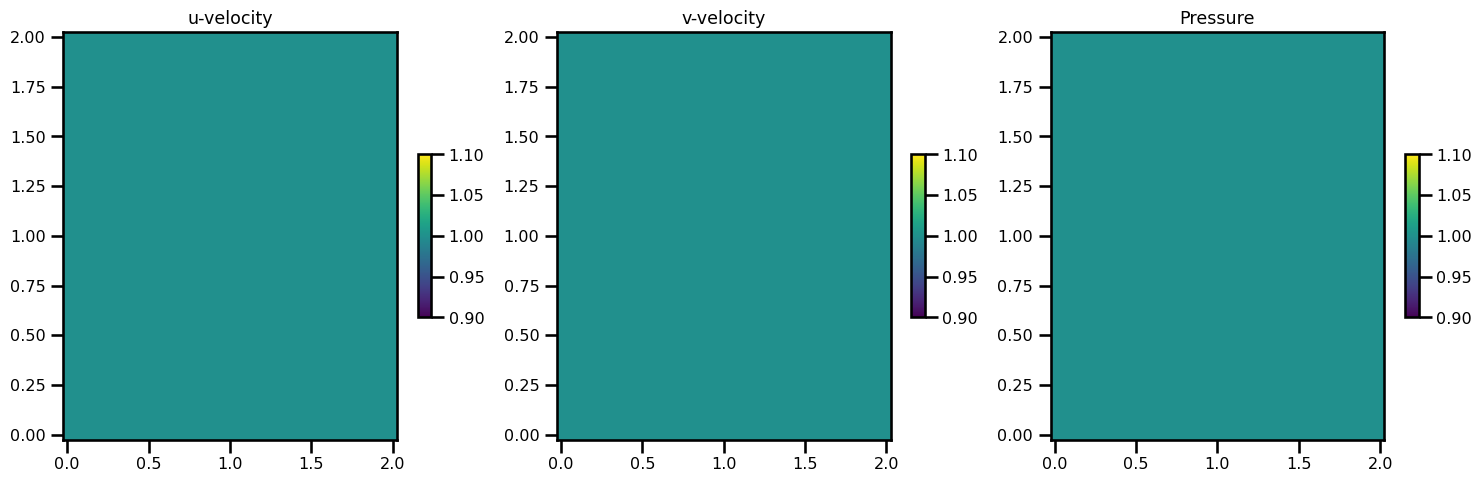

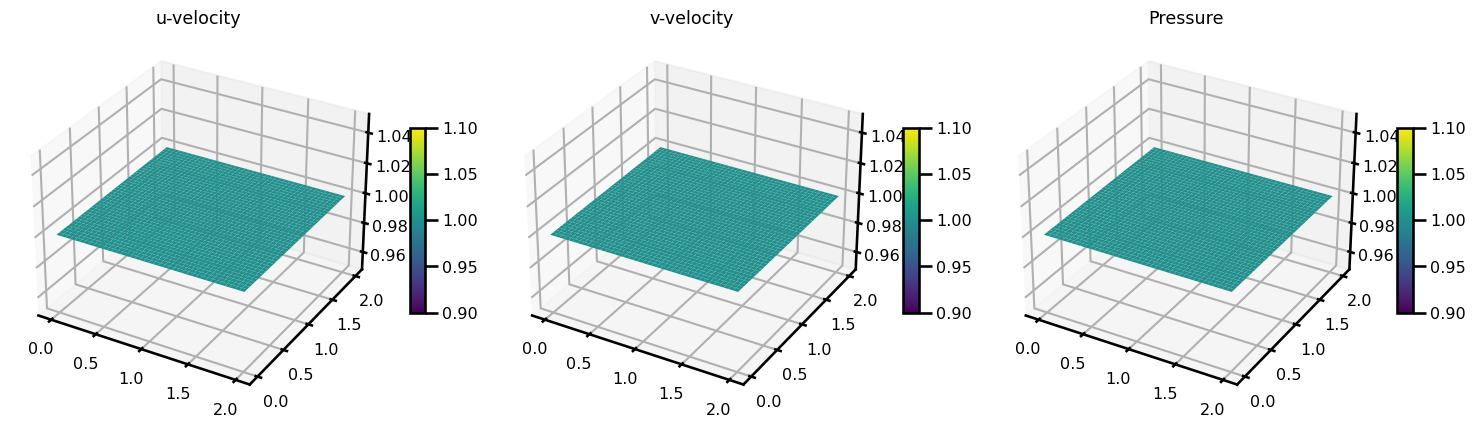

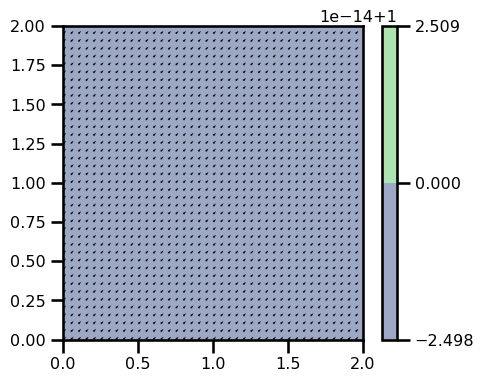

In [8]:
plot_state_2D(state)
plot_state_3D(state)
plot_vectorfield_2D(state)

### Boundary Conditions

We have some fancy boundary conditions because they depend upon the variable we are interested in.

**U-Velocities**

$$
\begin{aligned}
\mathcal{BC}[u](x,y) &= 
\begin{cases}
1 && && (y=L_y)\in\partial\Omega_y \\
0 && && (x,y) \in \partial\Omega
\end{cases}
\end{aligned}
$$


Note, we use the same BCs for both $u$ and $v$.

In [9]:
def boundaries_u(u: Array) -> Array:
    u = u.at[0,:].set(0.0)   # u(0,:) = 0
    u = u.at[-1,:].set(0.0)  # u(Lx,:) = 0
    u = u.at[:,0].set(0.0)   # u(:,0) = 0
    u = u.at[:,-1].set(1.0)  # u(:,Ly) = 1 (cavity lid)
    return u

**V-Velocities**

$$
\begin{aligned}
\mathcal{BC}[v](x,y) &= 0 && && (x,y) \in \partial\Omega
\end{aligned}
$$





In [10]:
def boundaries_v(v: Array) -> Array:
    v = v.at[0,:].set(0.0)   # v(0,:)  = 0
    v = v.at[-1,:].set(0.0)  # v(Lx,:) = 0
    v = v.at[:,0].set(0.0)   # v(:,0) = 0
    v = v.at[:,-1].set(0.0)  # v(:,Ly) = 0
    return v



**Pressure**. This is easily the most complicated BCs we have. They involve Dirichlet and Neumann.

$$
\begin{aligned}
\mathcal{BC}\left[\frac{\partial p}{\partial y} \right](x,y) &= 0 && && (x,y=0)\in\partial\Omega \\
\mathcal{BC}\left[p \right](x,y) &= 0 && && (y=L_y)\in\partial\Omega_y \\
\end{aligned}
$$

In [11]:
def boundaries_p(p: Array) -> Array:
    p = p.at[0,:].set(p[1,:])     # dp/dx = 0 @ x = 0
    p = p.at[-1,:].set(p[-2,:])   # dp/dx = 0 @ x = Lx
    # cavity entrance
    p = p.at[:,0].set(p[:,1])     # dp/dy = 0 @ y = 0
    # cavity lid (exit)
    p = p.at[:,-1].set(0.0)       # p = 0 @ y = Ly
    return p

In [12]:
u_bc = boundaries_u(state.u)
v_bc = boundaries_v(state.v)
p_bc = boundaries_v(state.p)

state = State.update_state(state, u=u_bc, v=v_bc, p=p_bc)

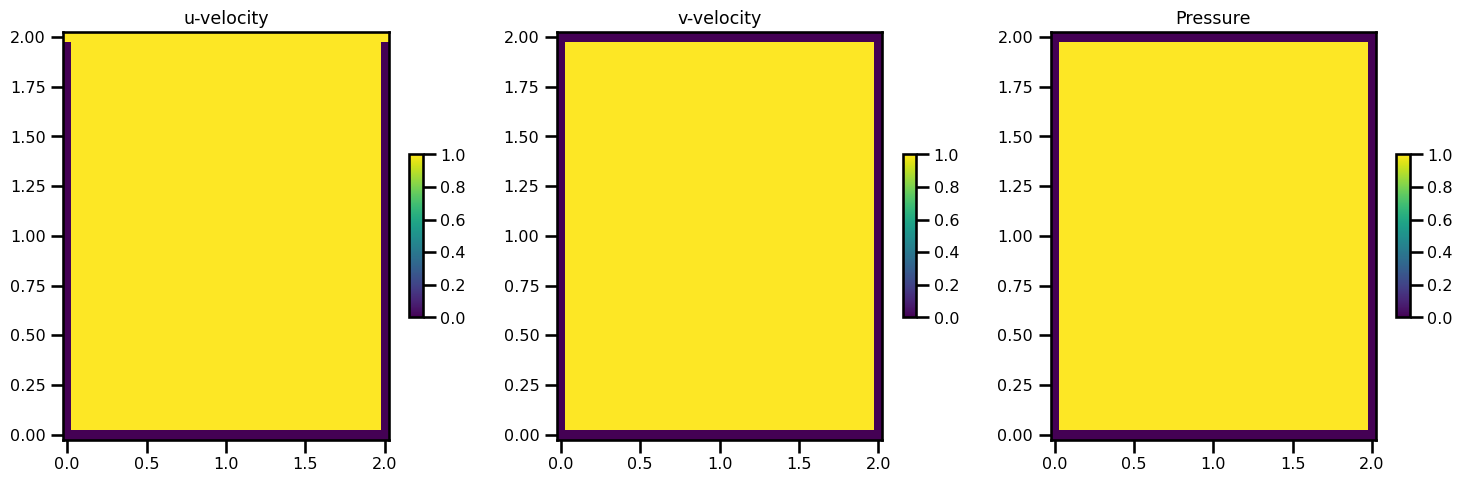

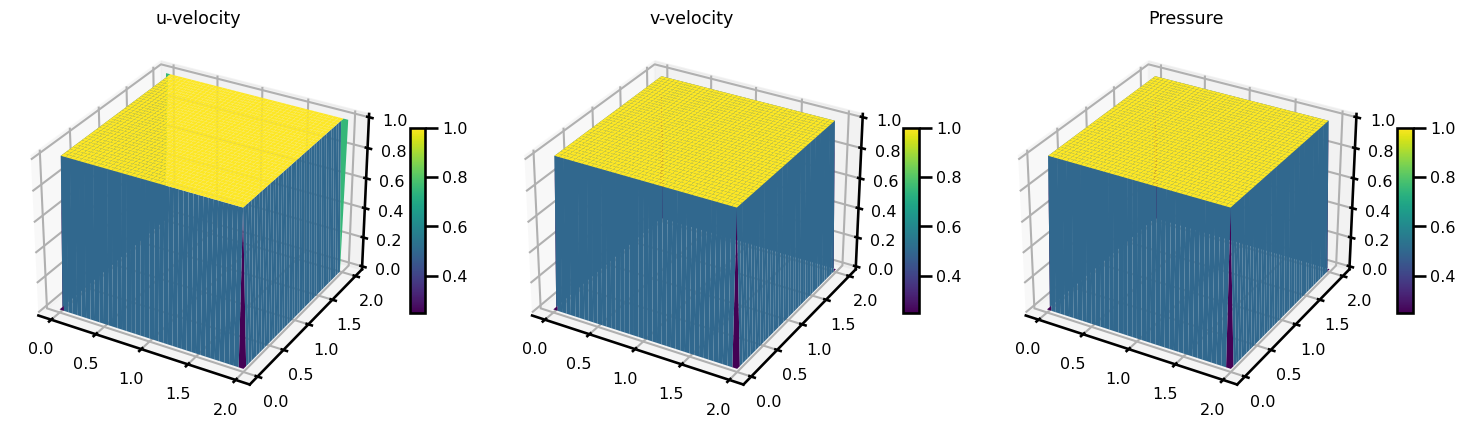

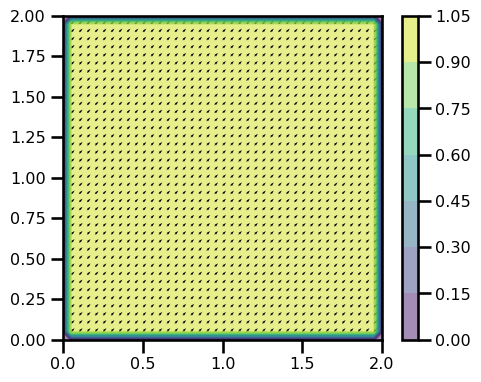

In [13]:
plot_state_2D(state)
plot_state_3D(state)
plot_vectorfield_2D(state)

## Equation of Motion

Now we need to create the equation of motion for the NS equation {eq}`eq:2d_ns`. However, there are many overlapping components. So we need to be a bit strategic when defining the functions. My personal strategy is the following:



**PDE Type**. I create generic PDEs for the advection, diffusion, and inversion terms. These should be generic functions because we may need to reuse these in later equations. 

**State Element**. I create the functions for each of the state variables ($u,v,p$). These are normally some combination of advection, diffusion, and inversion so hopefully I can reuse some of the above generic functions.

**Forcings**. These tend to be the tailored/handcrafted equations but often the most important. So I save these for last because this would often require the most individual tweaking compared to the main scheme.

### Sub PDEs

* Linear
* Advection
* Diffusion
* Elliptical

#### Advection Term

We have the advection term for both $u$ and $v$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 0 \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 0
\end{aligned}
$$

They recommend that we use the 1st order accurate backward difference scheme. We will make a generic advection function term that should work for both $u$ and $v$.

We can generically write this as:

$$
\text{Advection} :=  a(x,y)\frac{\partial u(x,t)}{\partial x} + b(x,y)\frac{\partial u(x,t)}{\partial y}
$$

In [14]:
def advection_term(u: Array, a: Array, b: Array, dx: int, dy: int, **kwargs) -> Array:
    """Generic 2D advection Term
    
    Equation:
        a ∂u/∂x + b ∂u/∂y
    """
    
    du_dx = fdx.difference(
        u, axis=0, step_size=dx,
        derivative=1, method="backward", **kwargs
    )
    du_dy = fdx.difference(
        u, axis=1, step_size=dy,
        derivative=1, method="backward", **kwargs
    )
    
    return a * du_dx + b * du_dy

In [15]:
out = advection_term(state.u, state.u, state.v, domain.dx[0], domain.dx[1], accuracy=1)

assert out.shape == state.u.shape == state.v.shape
print(out.min(), out.max())

state_out = State.update_state(state, u=out)

0.0 40.0


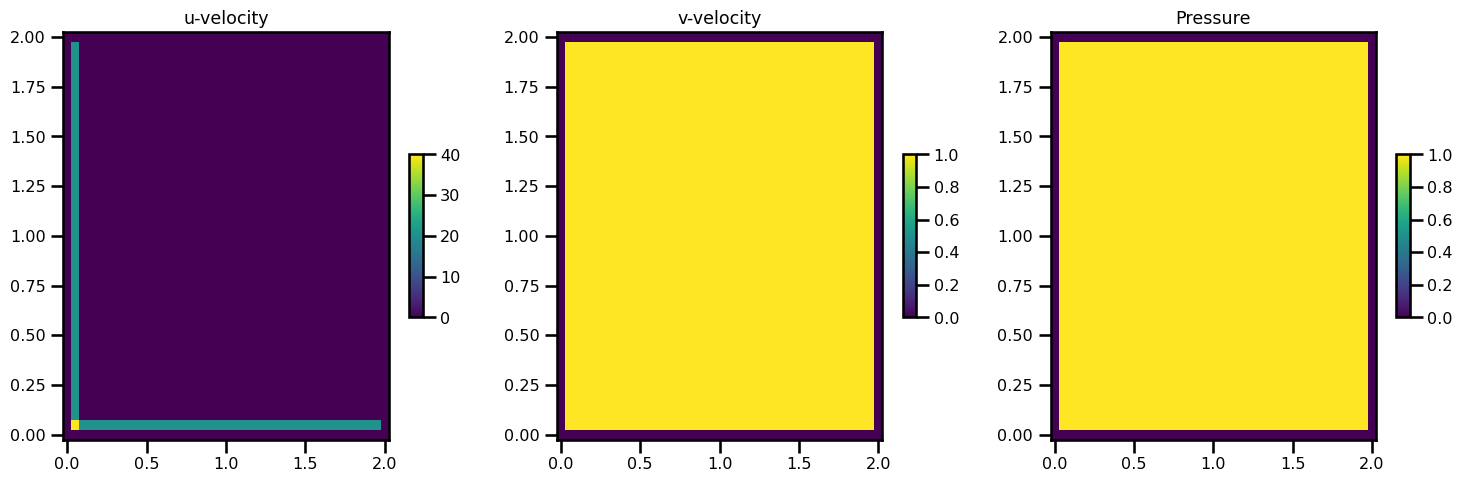

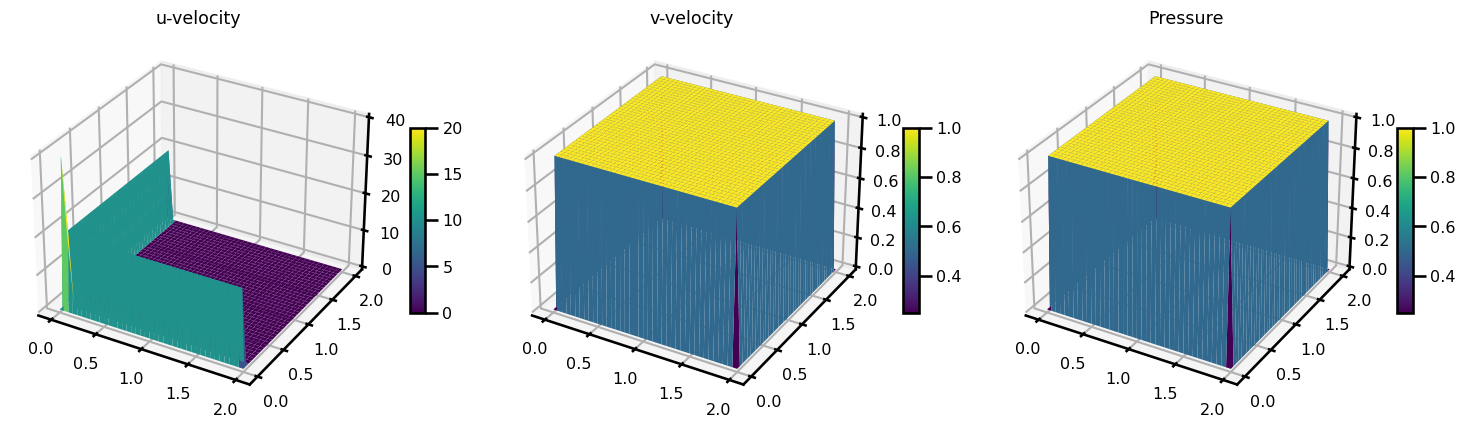

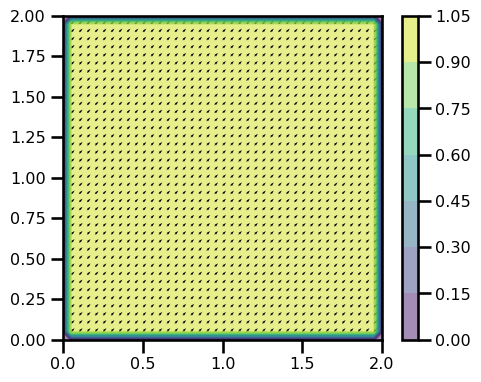

In [16]:
plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

#### Diffusion Term

Looking at the NS equation {eq}`eq:2d_ns`, we have the diffusion term for $u$ and $v$. Technically we have a diffusion term for pressure, $p$, but that's coupled to an elliptical equation so we won't count that.

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= 
\nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &= 
\nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right) \\
\end{aligned}
$$

They recommend that we use the 2nd order accurate central difference scheme. We will make a generic diffusion term that should work for both $u$ and $v$.

$$
\text{Diffusion} :=  \nu\left(\frac{\partial^2 u(x,t)}{\partial x^2} + \frac{\partial^2 u(x,t)}{\partial y^2}\right)
$$

In [17]:
def diffusion_term(u: Array, nu: Array, dx: int, dy: int, **kwargs) -> Array:
    """Generic 2D Diffusion Term
    
    Equation:
        ν (∂²u/∂x² + ∂²u/∂y²)
    
    """
    d2u_dx2 = fdx.difference(
        u, axis=0, step_size=dx,
        derivative=2, method="central", **kwargs
    )
    d2u_dy2 = fdx.difference(
        u, axis=1, step_size=dy,
        derivative=2, method="central", **kwargs
    )
    
    return nu * (d2u_dx2 + d2u_dy2)

In [18]:
out = diffusion_term(state.u, state.nu, domain.dx[0], domain.dx[1], accuracy=1)

assert out.shape == state.u.shape
out.min(), out.max()

(Array(-80., dtype=float64), Array(40., dtype=float64))

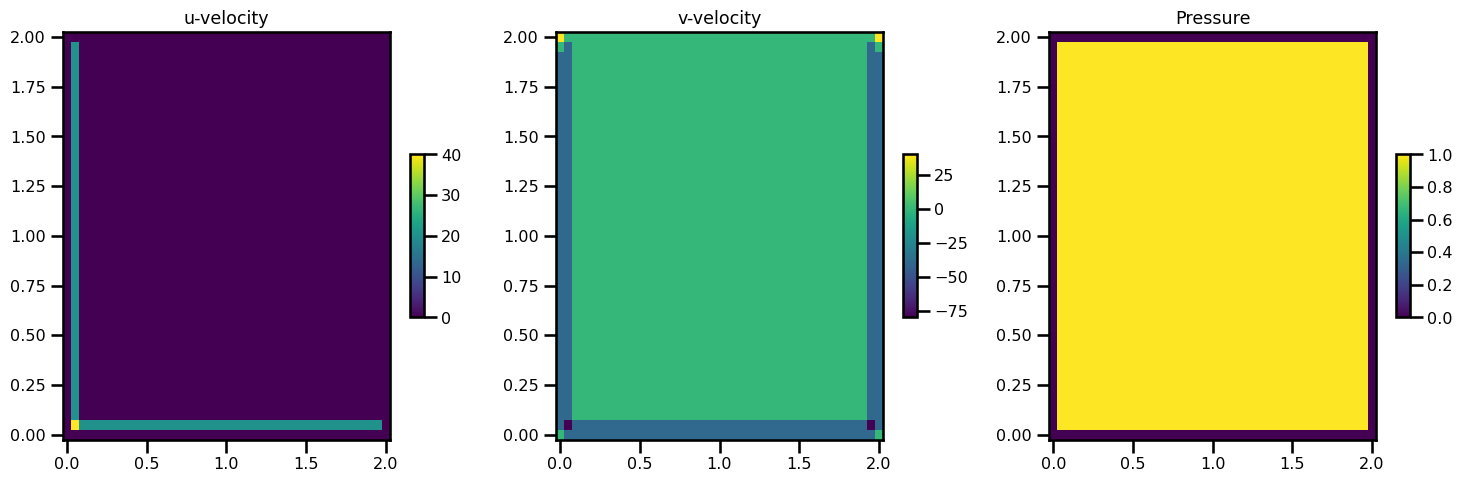

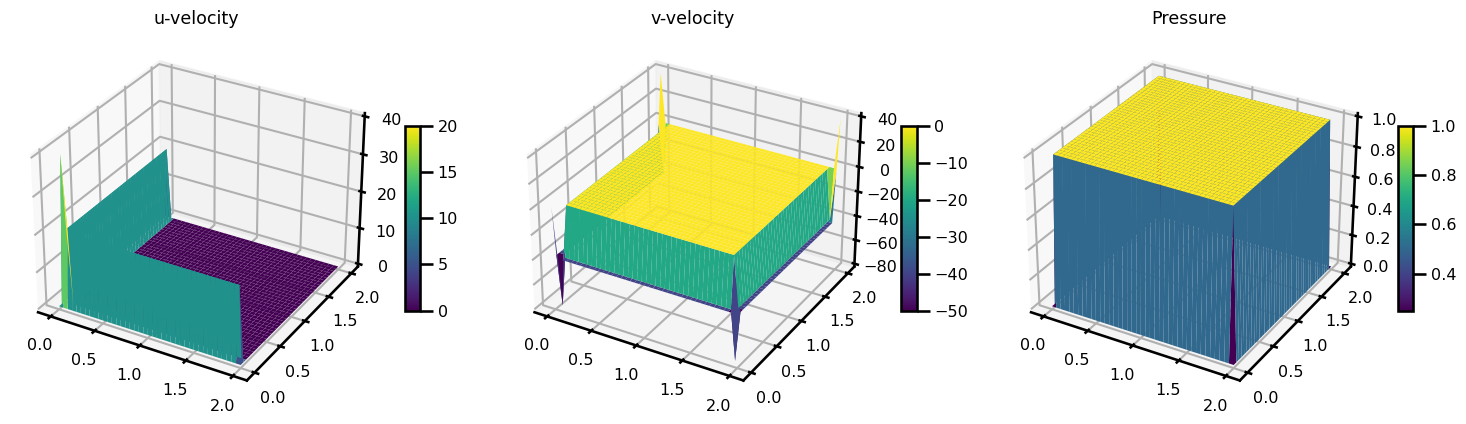

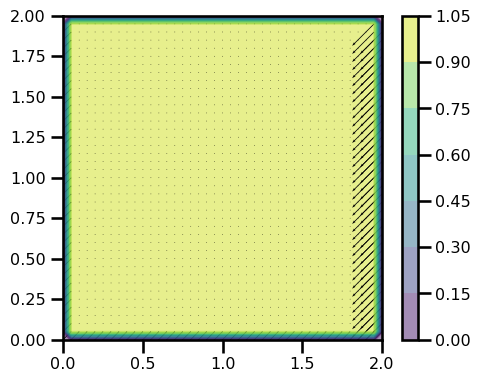

In [19]:
state_out = State.update_state(state_out, v=out)

plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

#### Combination-Reduction-Product (?)

Looking at the NS equation {eq}`eq:2d_ns`, we have this sort of combinatorial reduction productn for the pressure term. It's defined as

$$
\begin{aligned}
\frac{\partial p}{\partial t} &= 
-\rho \left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$

I don't have any recommendations for the type of scheme that we need for this... In any case, we can define a generic function for this:

$$
\text{VelocityProd} :=  -\rho \left( \frac{\partial u(x,t)}{\partial x}\frac{\partial u(x,y)}{\partial x} +
2 \frac{\partial u(x,y)}{\partial y}\frac{\partial v(x,y)}{\partial x} +
\frac{\partial v(x,y)}{\partial y}\frac{\partial v(x,y)}{\partial y}\right)
$$

In [20]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f

"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   \n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n\n'

In [21]:
def velprod_term(u: Array, v: Array, rho: Array, dx: int, dy: int, **kwargs) -> Array:
    """Generic 2D Diffusion Term
    
    Equation:
        -ρ ( ∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y )
    
    """
    du_dx = fdx.difference(
        u, axis=0, step_size=dx, derivative=1, **kwargs
    )
    du_dy = fdx.difference(
        u, axis=1, step_size=dy, derivative=1, **kwargs
    )
    dv_dx = fdx.difference(
        v, axis=0, step_size=dx, derivative=1, **kwargs
    )
    dv_dy = fdx.difference(
        v, axis=1, step_size=dy, derivative=1, **kwargs
    )
    
    return - rho * (
        du_dx * du_dx + 2 * du_dx * dv_dy + dv_dy * dv_dy
    )

In [22]:
out = velprod_term(state.u, state.v, state.rho, domain.dx[0], domain.dx[1], accuracy=1, method="backward")

assert out.shape == state.u.shape
out.min(), out.max()

(Array(-1600., dtype=float64), Array(-0., dtype=float64))

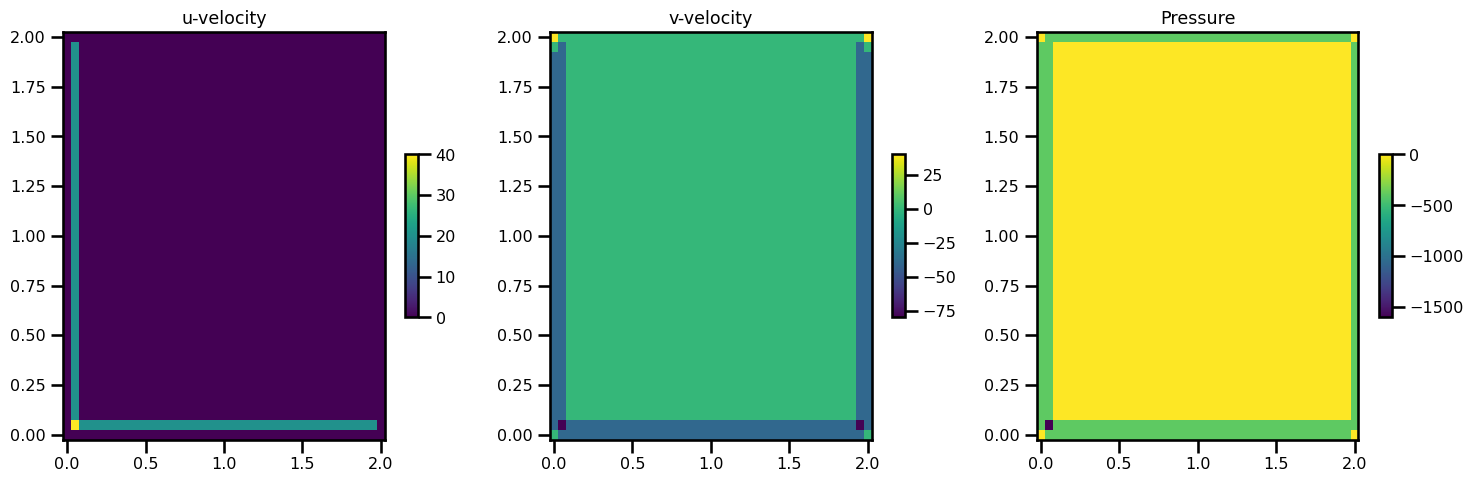

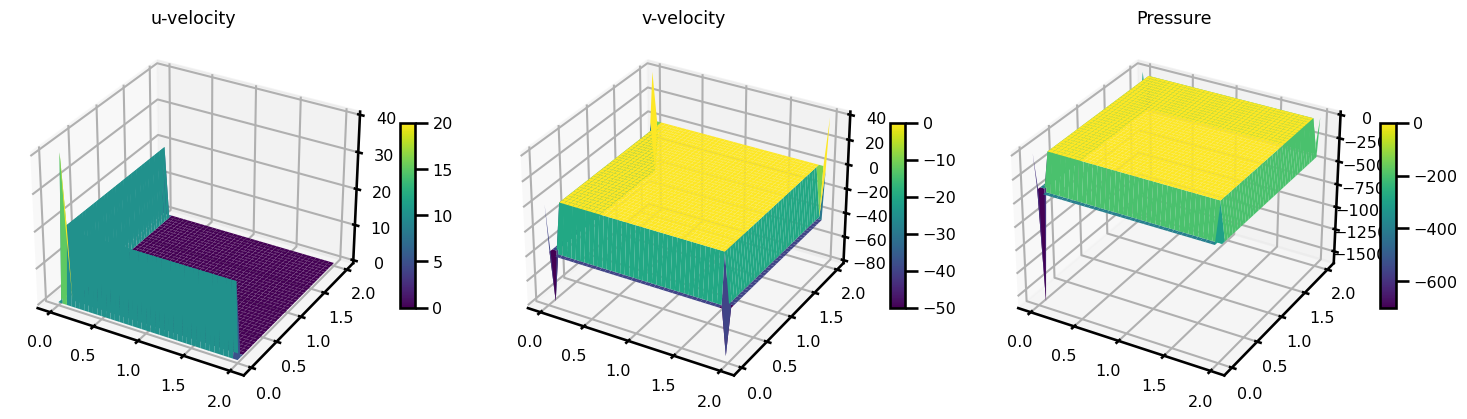

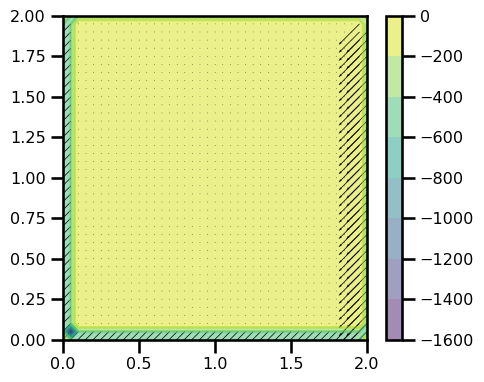

In [23]:
state_out = State.update_state(state_out, p=out)

plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

### U-Velocity

Looking at the NS equation {eq}`eq:2d_ns`, we can look at the u-velocity equation:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial x} +
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
\end{aligned}
$$ (eq:2d_ns)

In [24]:
def u_term(state: State) -> Array:
    
    # parse state, constants, steps
    u, v, p = state.u, state.v, state.p
    nu = state.nu
    dx, dy = state.domain.dx
    
    # linear term
    u_lin = fdx.difference(p, axis=0, step_size=dx, derivative=1, accuracy=1, method="central")
    
    # advection term
    u_adv = advection_term(u, a=u, b=v, dx=dx, dy=dy, accuracy=1)
    
    # diffusion term
    u_diff = diffusion_term(u, nu=nu, dx=dx, dy=dy, accuracy=1)
    
    return - (1./state.rho) * u_lin + u_diff - u_adv

In [25]:
u_out = u_term(state)

assert u_out.shape == state.u.shape
u_out.min(), u_out.max()

(Array(-130., dtype=float64), Array(40., dtype=float64))

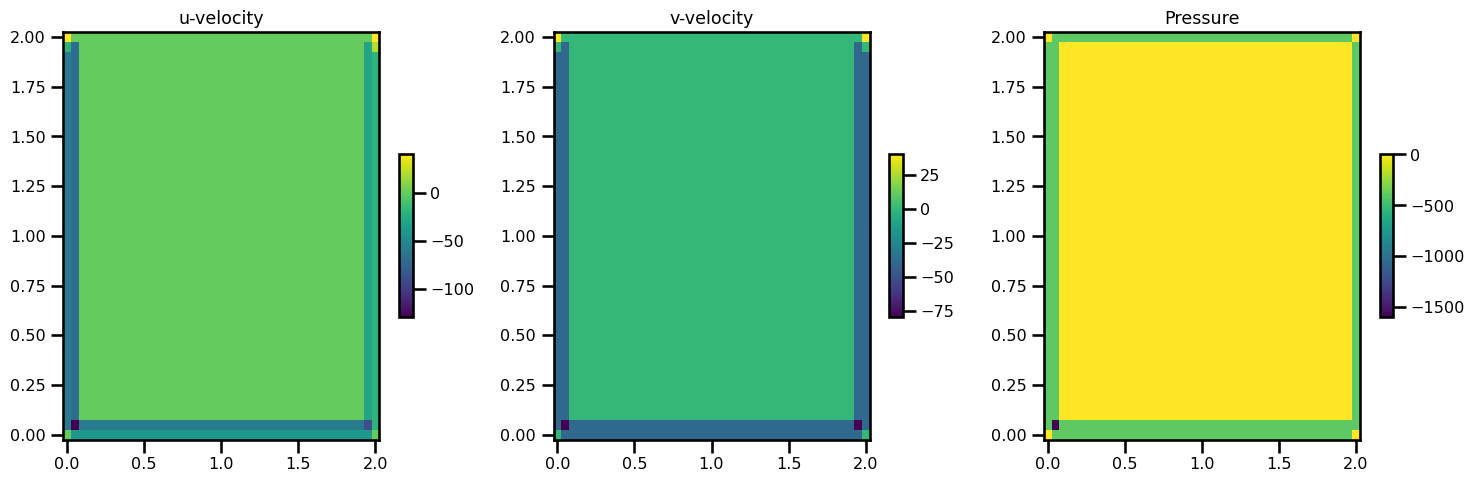

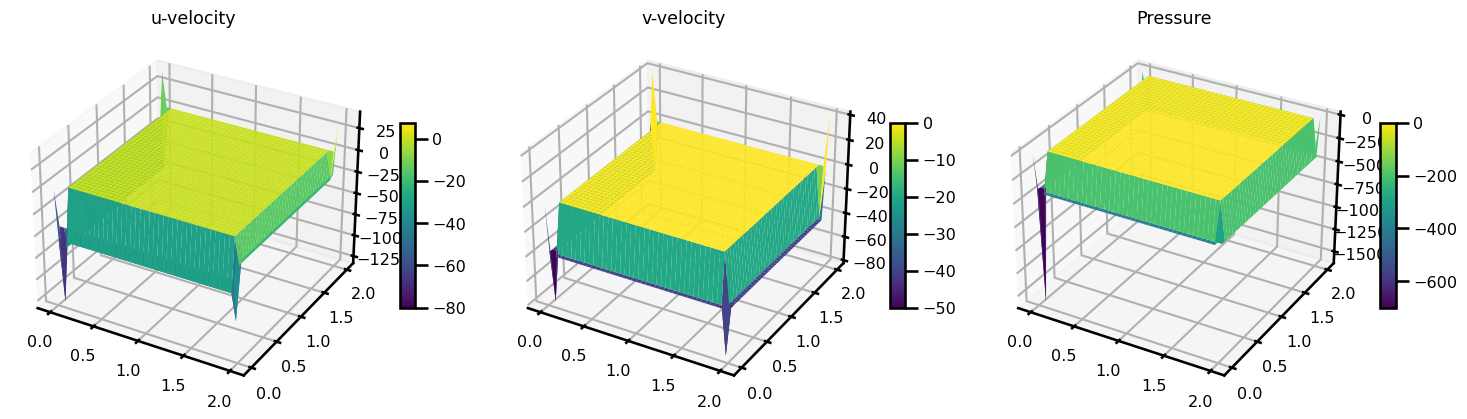

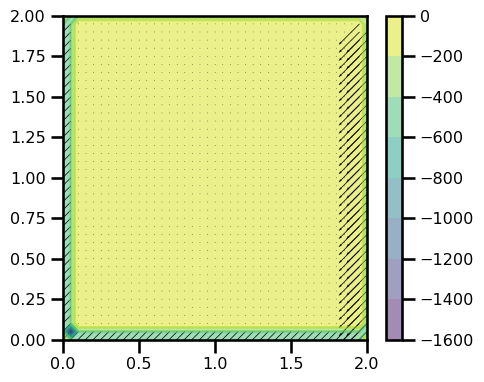

In [26]:
state_out = State.update_state(state_out, u=u_out)

plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

### V-Velocity Term

Looking at the NS equation {eq}`eq:2d_ns`, we can look at the v-velocity equation:

$$
\begin{aligned}
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial y} +
\nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{aligned}
$$ (eq:2d_ns)

In [27]:
def v_term(state: State) -> Array:
    
    # parse state, constants, steps
    u, v, p = state.u, state.v, state.p
    nu = state.nu
    dx, dy = state.domain.dx
    
    # linear term
    v_lin = fdx.difference(
        p, axis=1, step_size=dy, derivative=1, accuracy=1, method="central"
    )
    
    # advection term
    v_adv = advection_term(v, a=u, b=v, dx=dx, dy=dy, accuracy=1)
    
    # diffusion term
    v_diff = diffusion_term(v, nu=nu, dx=dx, dy=dy, accuracy=1)
    
    return - (1./state.rho) * v_lin + v_diff - v_adv

In [28]:
v_out = v_term(state)

assert v_out.shape == state.v.shape
v_out.min(), v_out.max()

(Array(-130., dtype=float64), Array(0., dtype=float64))

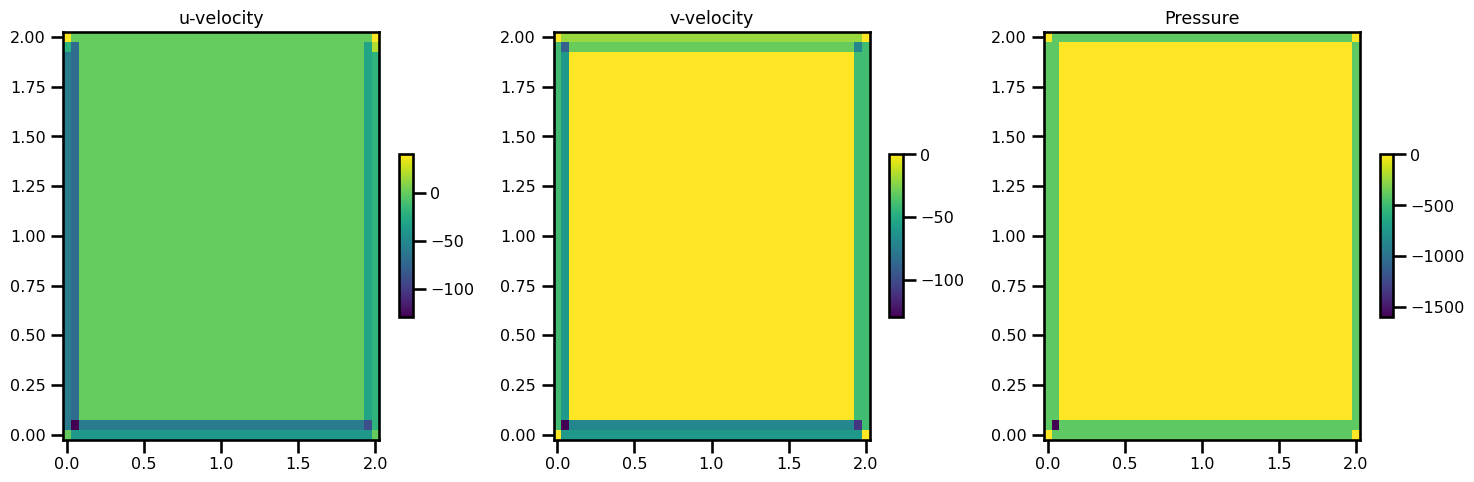

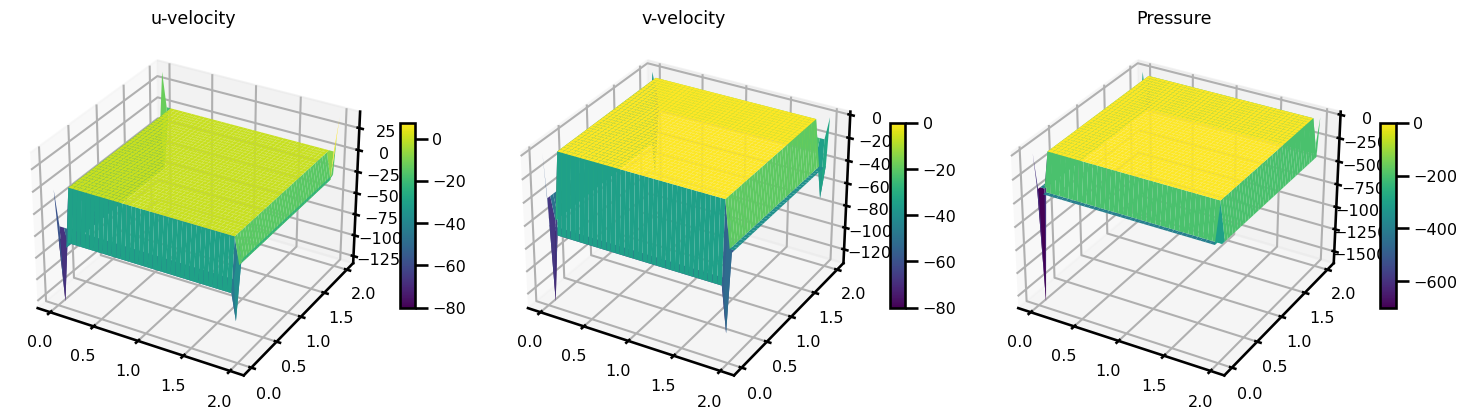

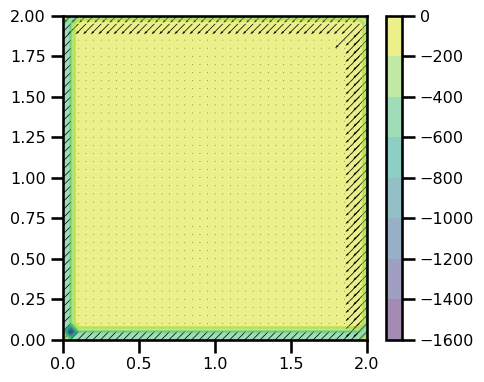

In [29]:
state_out = State.update_state(state_out, v=v_out)

plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

### Pressure Term

$$
\begin{aligned}
\frac{\partial^2 p}{\partial x^2} &+ \frac{\partial^2 p}{\partial y^2}  =
-\rho\left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$ (eq:2d_ns_p)

The only tricky thing about this is that we actually have an inversion problem.

$$
\begin{aligned}
\nabla^2 p &= f(x,y) \\
\mathbf{L}p &= \mathbf{F}\\
\end{aligned}
$$

In [70]:
from jaxopt import linear_solve
from jaxsw._src.utils.linear_solver import conjugate_gradient, steepest_descent

def p_term(state: State, tol:float=1e-5, maxiters: int=100) -> Array:
    
    # parse state, constants, steps
    u, v, p = state.u, state.v, state.p
    nu = state.nu
    dx, dy = state.domain.dx
    
    # define matrix multiplcation term
    def matvec_Lp(u):
        u_lap = fdx.laplacian(
            u,  
            step_size=(state.domain.dx[0], state.domain.dx[1]),
            accuracy=1,
            method="central"
        )
        
        u_lap = boundaries_p(u_lap)
        return u_lap
    
    # define RHS
    b = velprod_term(u, v, rho=rho, dx=dx, dy=dy, accuracy=1)
    
    pnew = steepest_descent(
        b, matvec_fn=matvec_Lp, 
        # u_init=p,
        target_criterion=tol,
        max_iterations=maxiters
    ).u
    # pnew = linear_solve.solve_cg(matvec=matvec_Lp, b=b, init=p, tol=1e-5)
    
    return pnew

In [73]:
p_out = p_term(state, maxiters=10000, tol=1e-10)

assert p_out.shape == state.p.shape
p_out.min(), p_out.max()

(Array(0., dtype=float64), Array(131717.93426752, dtype=float64))

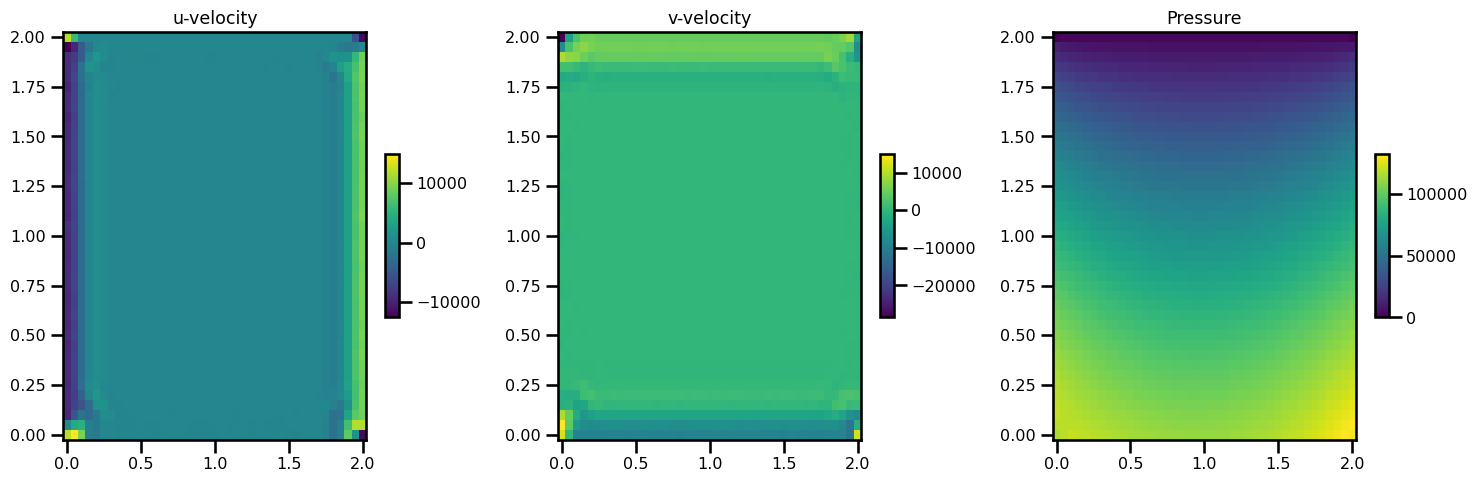

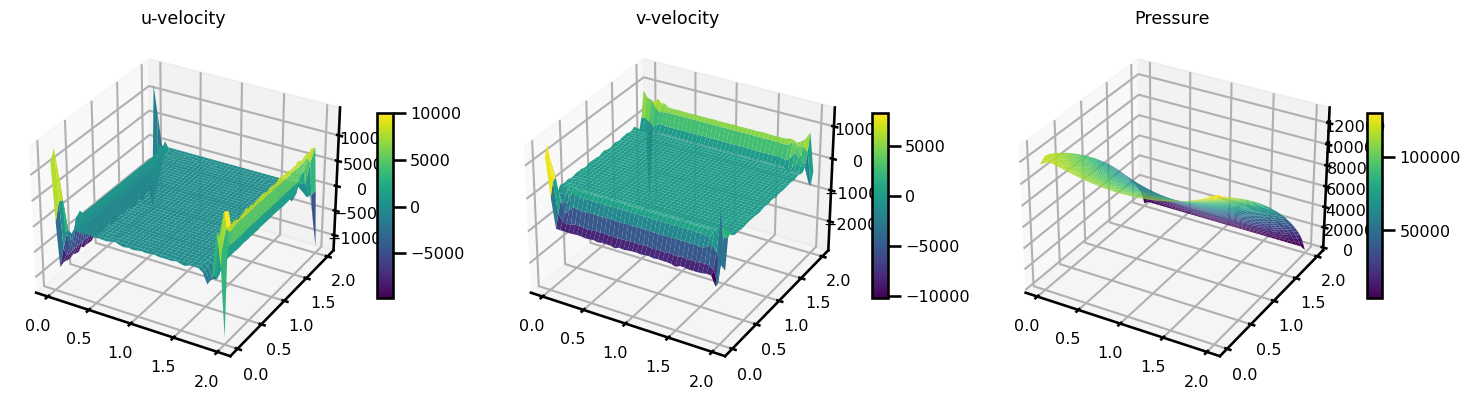

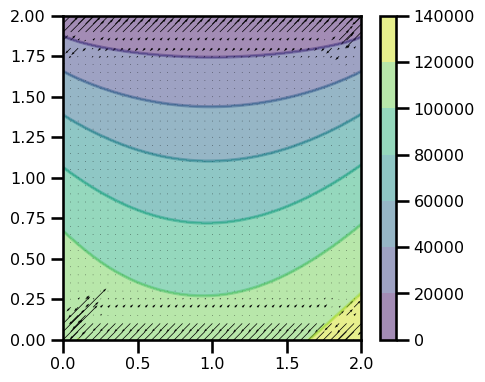

In [74]:
state_out = State.update_state(state_out, p=p_out)

plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

### Equation of Motion

$$
\begin{aligned}
p &= \boldsymbol{f_p}(u,v,\theta) \\
\frac{\partial u}{\partial t} &= \boldsymbol{f_u}(u,v,p,\theta) \\
\frac{\partial v}{\partial t} &= \boldsymbol{f_v}(u,v,p,\theta)
\end{aligned}
$$ (eq:2d_ns)

In [75]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f

"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   \n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n\n'

In [90]:


class NavierStokes2D(DynamicalSystem):
    
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Navier-Stokes Equation

        Equation:
            ∂u/∂t + u ∂u/∂x + v ∂u/∂y = -ρ ∂p/∂x + ν (∂²u/∂x² + ∂²u/∂y²)
            ∂v/∂t + u ∂v/∂x + v ∂v/∂y = -ρ ∂p/∂y + ν (∂²v/∂x² + ∂²v/∂y²)
            ∂²p/∂x² + ∂²p/∂y² = -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
        """
        
        # unpack state
        u, v, p = state.u, state.v, state.p
        
        # enforce boundary conditions
        u = boundaries_u(u)
        v = boundaries_v(v)
        p = boundaries_p(p)
        
        # update state
        state = State.update_state(state, u=u, v=v, p=p)
        
        # update each term
        p = p_term(state, tol=1e-10, maxiters=100)
        state = State.update_state(state, p=p)
        
        
        u = u_term(state)
        v = v_term(state)
        
        
        # update state
        state = State.update_state(state, u=u, v=v, p=p)
        
        return state
    


In [91]:
#SPATIAL DISCRETIZATION
# initialize state
state_init = State.init_state(domain, nu=nu, rho=rho, init_fn=init_u0)

# right hand side
state_out = NavierStokes2D.equation_of_motion(0, state_init, 0)

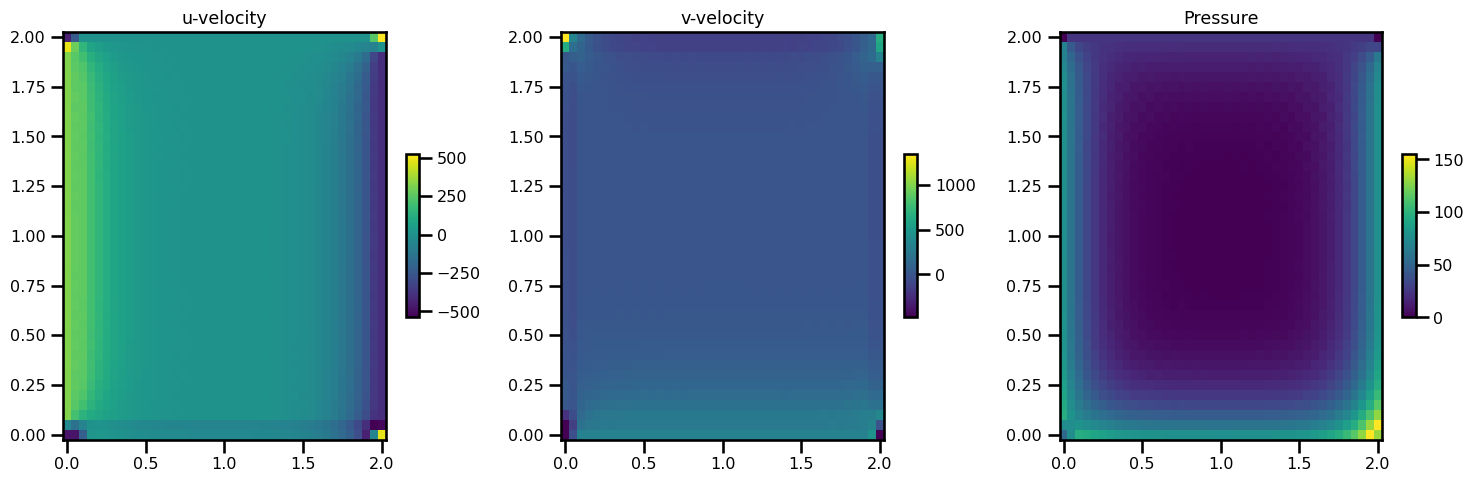

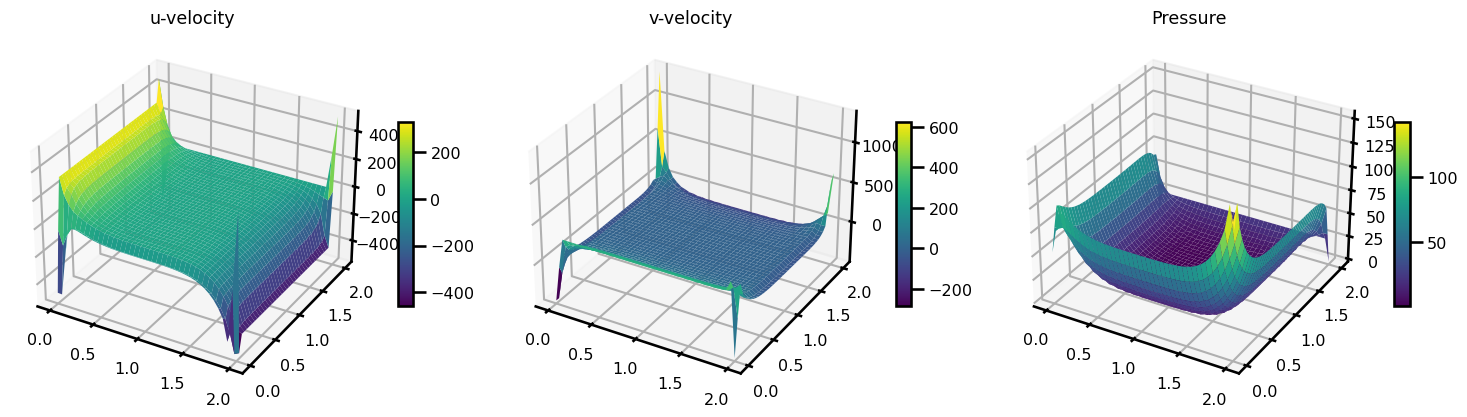

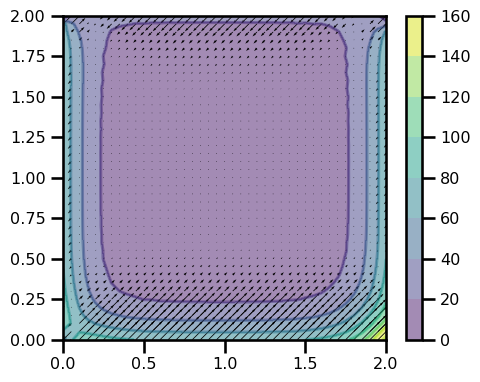

In [92]:
plot_state_2D(state_out)
plot_state_3D(state_out)
plot_vectorfield_2D(state_out)

## Time Stepping

Here we use the Euler method with a constant stepsize.

#### CFD Condition

In [93]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

sigma = 0.0009
nu = 0.1
rho = 1.0
dt = 0.001 #sigma * domain.dx[0] * domain.dx[1] / nu
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = 0.01 #(np.arange(120) * dt).max()
num_save = 20

Step Size (dt): 1.0000e-03


In [94]:
# SPATIAL DISCRETIZATION
state_init = State.init_state(domain, nu=nu, rho=rho, init_fn=init_u0)

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = NavierStokes2D(t_domain=t_domain, saveat=saveat)

# integration
state_sol = dyn_model.integrate(state_init, dt)

In [95]:
state_sol.u[-1].min(), state_sol.u[-1].min()

(Array(-2.61741034e+24, dtype=float64), Array(-2.61741034e+24, dtype=float64))

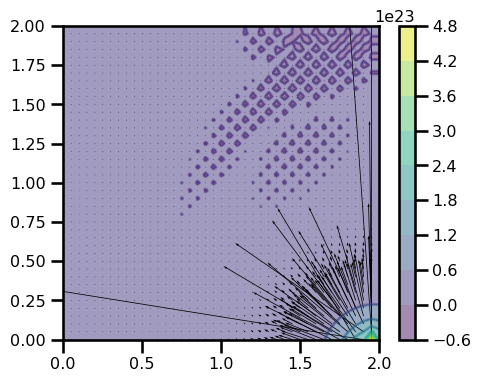

In [96]:
plot_vectorfield_2D(state_sol, axis=-1)

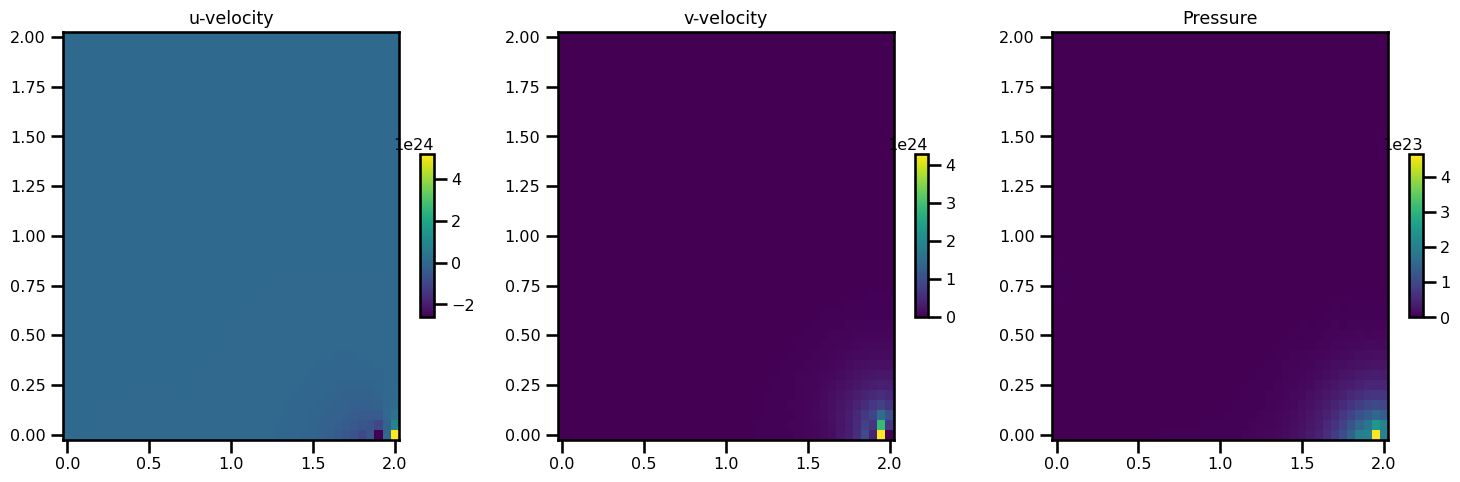

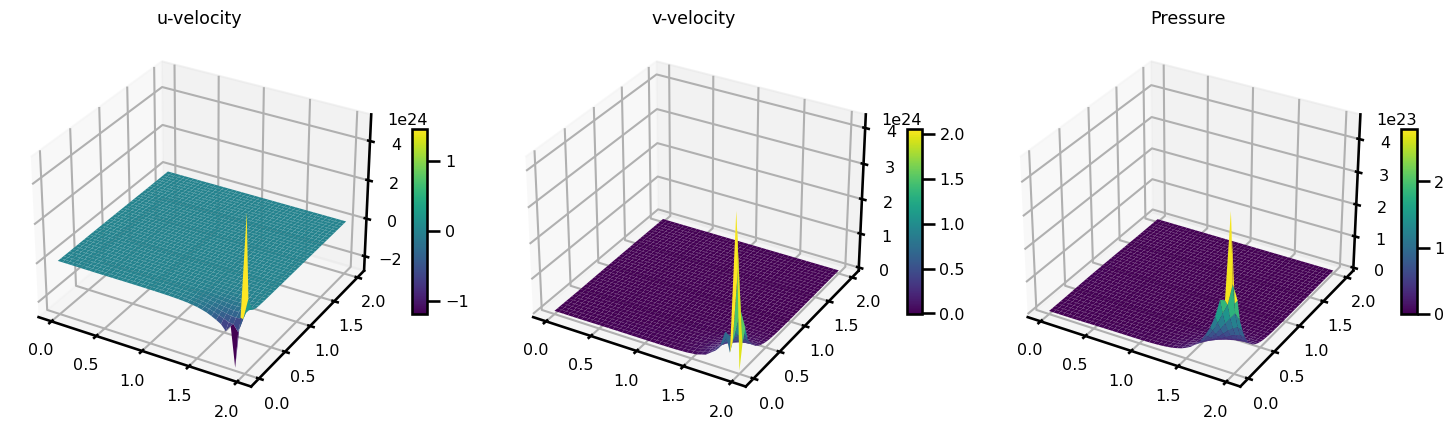

In [97]:
plot_state_2D(state_sol, axis=-1)
plot_state_3D(state_sol, axis=-1)
